## **Build a Binary Classification model**

### We will use the data obtained in the descriptor generator example

In [83]:
import pandas as pd
import numpy as np

from mlchem.ml.feature_selection import filters,wrappers
from mlchem.ml.preprocessing import scaling, undersampling, feature_transformation
from sklearn.model_selection import train_test_split
from mlchem.metrics import get_geometric_S
from mlchem.helper import suppress_warnings


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib

suppress_warnings()

In [86]:
df_desc_rdkit = pd.read_csv('../data/data_rdkit.csv',index_col='SMILES')
data = pd.read_csv('../data/data.csv')
df_desc_rdkit['CLASS'] = data.CLASS.values

In [87]:
df_desc_rdkit.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,CLASS
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCC=C=NCCCCO,8.437125,8.437125,0.272018,0.272018,0.460034,8.909091,155.241,138.105,155.131014,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0
CCCCCOCCCC=C=NCCCCO,8.559624,8.559624,0.258536,0.258536,0.421419,10.000000,241.375,214.159,241.204179,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0
CCCOCC(C)O,8.653994,8.653994,0.318009,-0.318009,0.552991,13.875000,118.176,104.064,118.099380,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CC(CS#CCO)OCCCC=CN,8.460126,8.460126,0.001308,-0.001308,0.659917,12.714286,217.334,198.182,217.113650,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
CS#CCCNCCO,8.334665,8.334665,0.221496,0.221496,0.559815,8.666667,147.243,134.139,147.071785,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Preprocess data and take care of class imbalance

In [88]:
train_set,test_set,y_train,y_test = train_test_split(df_desc_rdkit,list(df_desc_rdkit.CLASS.values),test_size=0.2,stratify=list(df_desc_rdkit.CLASS.values),random_state=1)
undersampling.check_class_balance(y_train)
print()
undersampling.check_class_balance(y_test)

CLASS BALANCE



[0]: 240  [1]: 236  (0.50/0.50)

CLASS BALANCE



[0]: 60  [1]: 60  (0.50/0.50)


#### Take care of imbalance if more extreme than 60/40

In [32]:
train_set,test_set = undersampling.undersample(train_set=train_set,test_set=test_set,class_column='CLASS',desired_proportion_majority=0.6,add_dropped_to_test=True)

Samples to remove: 65
CLASS BALANCE



[0]: 90  [1]: 135 (0.40/ 0.60)


In [33]:
print(train_set.shape,test_set.shape)

undersampling.check_class_balance(train_set.CLASS.to_list())
print()
undersampling.check_class_balance(test_set.CLASS.to_list())

(225, 211) (138, 211)
CLASS BALANCE



[0]: 90  [1]: 135  (0.40/0.60)

CLASS BALANCE



[0]: 23  [1]: 115  (0.17/0.83)


### Add interaction terms to descriptors (degree=1 will change nothing)

In [89]:
degree = 1
train_set_poly = feature_transformation.polynomial_expansion(train_set.iloc[:,:-1],degree)
test_set_poly = feature_transformation.polynomial_expansion(test_set.iloc[:,:-1],degree)

train_set_poly['CLASS'] = train_set['CLASS']
test_set_poly['CLASS'] = test_set['CLASS']

In [90]:
train_set_poly

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,CLASS
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCCC(C)CCC,2.360278,2.360278,0.967546,0.967546,0.530272,13.666667,128.259,108.099,128.156501,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
C1=CC2CCCC2O1,5.296296,5.296296,0.564815,0.564815,0.460854,42.000000,110.156,100.076,110.073165,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
C=CCC=C(C=NCCC#CC=CC)NCO,8.766427,8.766427,0.101095,-0.101095,0.231820,11.529412,232.327,212.167,232.157563,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
O=[N+]CC=NC#CO,9.316073,9.316073,0.005278,-0.005278,0.384481,8.000000,112.088,108.056,112.026729,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
O=CCC#CCO,9.495547,9.495547,0.158889,-0.158889,0.356716,6.428571,98.101,92.053,98.036779,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N=C=C=CO,7.647639,7.647639,0.631944,0.631944,0.242066,4.000000,69.063,66.039,69.021464,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
C#CCPC(O)CC,8.905818,8.905818,0.161065,-0.161065,0.446499,14.125000,130.127,119.039,130.054752,46.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
CC#COCCCC,4.862083,4.862083,0.775139,0.775139,0.399207,7.250000,112.172,100.076,112.088815,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Filter and scale data

#### filter

In [ ]:
# usual values: ~0.8, ~0.1
# For this application we want to make a sparser model

multicollinearity_threshold = 0.4
diversity_threshold = 0.4

print(train_set_poly.shape)
train_set_poly_filter_1 = filters.diversity_filter(train_set_poly,diversity_threshold,'CLASS')
print(train_set_poly_filter_1.shape)


train_set_poly_filter_2 = filters.collinearity_filter(train_set_poly_filter_1,multicollinearity_threshold,'CLASS')
print(train_set_poly_filter_2.shape)

test_set_poly_filter_2 = test_set_poly[train_set_poly_filter_2.columns]
train_set_poly_filter_2

(476, 205)
(476, 91)
(476, 29)


,MaxAbsEStateIndex,MinEStateIndex,qed,MolLogP,FpDensityMorgan3,BalabanJ,PEOE_VSA10,PEOE_VSA8,PEOE_VSA9,SMR_VSA10,...,VSA_EState8,FractionCSP3,SMR_VSA1,fr_C_O_noCOO,fr_NH0,fr_NH1,fr_allylic_oxid,fr_ether,fr_unbrch_alkane,CLASS
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCCC(C)CCC,2.360278,0.967546,0.530272,3.61280,2.111111,2.954823,0.000000,0.000000,0.000000,0.000000,...,6.889158,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1
C1=CC2CCCC2O1,5.296296,0.564815,0.460854,1.69900,3.250000,2.127464,6.103966,5.917906,6.262080,0.000000,...,0.000000,0.714286,4.736863,0.0,0.0,0.0,0.0,1.0,0.0,1
C=CCC=C(C=NCCC#CC=CC)NCO,8.766427,-0.101095,0.231820,2.02620,3.000000,4.009715,6.730817,19.180179,5.697039,6.214601,...,6.116299,0.357143,5.106527,0.0,1.0,1.0,5.0,0.0,0.0,0
O=[N+]CC=NC#CO,9.316073,-0.005278,0.384481,-0.54970,3.125000,3.290868,6.106495,0.000000,17.166035,6.214601,...,-0.005278,0.250000,5.106527,0.0,2.0,0.0,0.0,0.0,0.0,0
O=CCC#CCO,9.495547,-0.158889,0.356716,-0.42890,2.714286,3.064456,12.893042,0.000000,6.420822,6.286161,...,-0.158889,0.400000,9.901065,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N=C=C=CO,7.647639,0.631944,0.242066,0.46167,2.400000,3.746822,6.262080,5.869799,0.000000,5.869799,...,0.000000,0.000000,5.106527,0.0,0.0,1.0,0.0,0.0,0.0,0
C#CCPC(O)CC,8.905818,-0.161065,0.446499,1.02650,2.875000,3.010322,0.000000,6.161910,5.845055,8.580697,...,1.952563,0.666667,5.106527,0.0,0.0,0.0,0.0,0.0,0.0,1
CC#COCCCC,4.862083,0.775139,0.399207,1.78390,2.750000,2.789000,12.713377,6.923737,0.000000,0.000000,...,4.672639,0.714286,4.736863,0.0,0.0,0.0,0.0,1.0,1.0,1


In [113]:
(train_set_poly_filter_2.corr()**2)['CLASS'].to_frame().sort_values('CLASS',ascending=False).head()

,CLASS
CLASS,1.000000
MaxAbsEStateIndex,0.226778
EState_VSA9,0.184628
SMR_VSA1,0.177902
EState_VSA2,0.162938


#### scale

###### continuous

In [114]:
train_set_scaled, train_scaler = scaling.scale_df_standard(train_set_poly_filter_2,1)
test_set_scaled = scaling.transform_df(test_set_poly_filter_2,train_scaler,1)[0]

y_train = train_set_poly.CLASS.values
y_test = test_set_poly.CLASS.values

###### categorical

In [ ]:
train_set_scaled = train_set_poly_filter_2.copy().iloc[:,:-1]
test_set_scaled = test_set_poly_filter_2.copy().iloc[:,:-1]

#train_set_scaled['CLASS'] = train_set_poly['CLASS']
#test_set_scaled['CLASS'] = test_set_poly['CLASS']


y_train = train_set_poly.CLASS.values
y_test = test_set_poly.CLASS.values

## Modelling - explore wrappers (*Sequential Feature Selection* and *Combinatorial Selection*)

### Sequential Feature Selection

In [115]:
SFS = wrappers.SequentialForwardSelection
estimator = LogisticRegression(penalty='l2',C=.1,solver='liblinear',random_state=1)

sfs = SFS(estimator=estimator,
          estimator_string='Logistic Regression simple model',
          metric=get_geometric_S,
          max_features=10,
          cv_iter=5,
          logic='greater',
          task_type='classfication')

sfs.fit(train_set=train_set_scaled,test_set=test_set_scaled,
                y_train=y_train,y_test=y_test)

010/010 [==================================================]

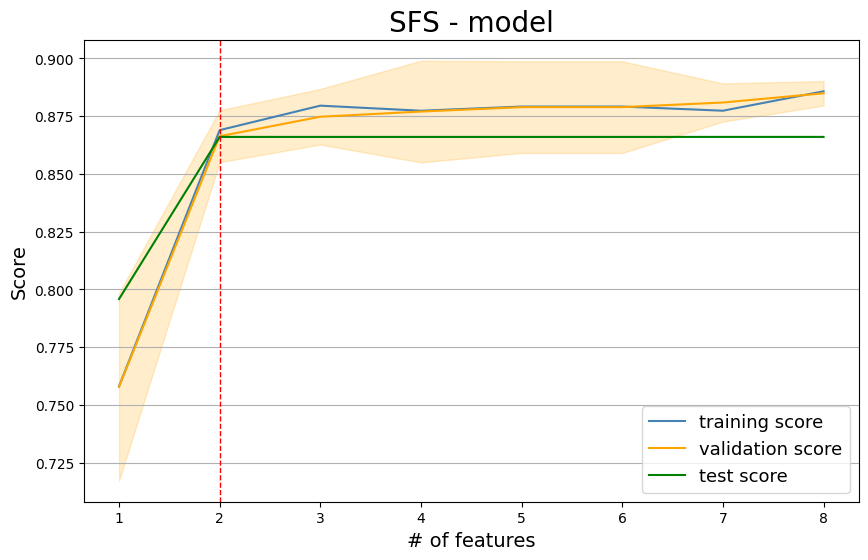

Number of features: 2
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO']
Train Score: 0.869
CV Score: 0.866 ± 0.011
Test Score: 0.866


In [127]:
sfs.plot(best_feature=2)

### Combinatorial Selection

In [121]:
COMB = wrappers.CombinatorialSelection
comb = COMB(estimator=estimator,metric=get_geometric_S,logic='greater',
            task_type='classification')

results_1 = comb.fit_stage_1(train_set=train_set_scaled,
                             test_set=test_set_scaled,
                             y_train=y_train,
                             y_test=y_test,
                             features=train_set_scaled.columns,
                             k=2,
                             training_threshold=0.7,
                             cv_train_ratio=0.8,
                             cv_iter=5)
results_2 = comb.fit_stage_2(top_n_subsets=5,cv_iter=5)

031/031 [==================================================]

In [122]:
results_2.head()

,feature_subsets,training_score,cv_score,test_score,geometric_mean
11,"[MaxAbsEStateIndex, VSA_EState4, fr_C_O_noCOO]",0.873162,0.870613,0.866025,0.869928
10,"[MaxAbsEStateIndex, SMR_VSA1, fr_C_O_noCOO]",0.868956,0.859292,0.874007,0.867397
18,"[EState_VSA9, MaxAbsEStateIndex, SMR_VSA1, VSA...",0.862348,0.857060,0.882704,0.867301
5,"[MaxAbsEStateIndex, fr_C_O_noCOO]",0.868956,0.866323,0.866025,0.867101
17,"[MaxAbsEStateIndex, SMR_VSA1, VSA_EState4, fr_...",0.864556,0.861546,0.874007,0.866687


## **Modelling** - try a different learning algorithm *and* different hyperparameter combinations

### For both SFS and COMB, automatically save best model and associated features

In [123]:
joblib.dump(train_set,'../data/train_set_rdkit')
joblib.dump(test_set,'../data/test_set_rdkit')

['../data/test_set_rdkit']

In [124]:
max_features = 8
training_threshold = 0.75
cv_train_ratio = 0.8
cv_iter = 5
top_n_subsets = 5
k = 2

### K Nearest Neighbours


KNN_3


008/008 [==================================================]

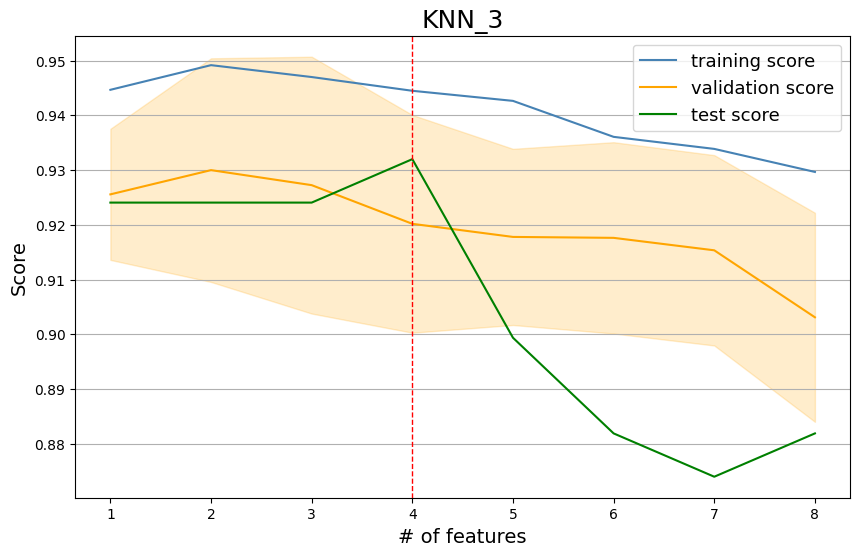

Number of features: 4
Winner feature subset: ['SMR_VSA1', 'fr_C_O_noCOO', 'MaxAbsEStateIndex', 'SlogP_VSA4']
Train Score: 0.944
CV Score: 0.920 ± 0.020
Test Score: 0.932




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 2
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.949
CV Score: 0.930 ± 0.020
Test Score: 0.924

# of Features: 3
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO', 'fr_ether']
Train Score: 0.949
CV Score: 0.925 ± 0.025
Test Score: 0.924

# of Features: 1
Best Features: ['SMR_VSA1']
Train Score: 0.945
CV Score: 0.926 ± 0.012
Test Score: 0.924






KNN_5


008/008 [==================================================]

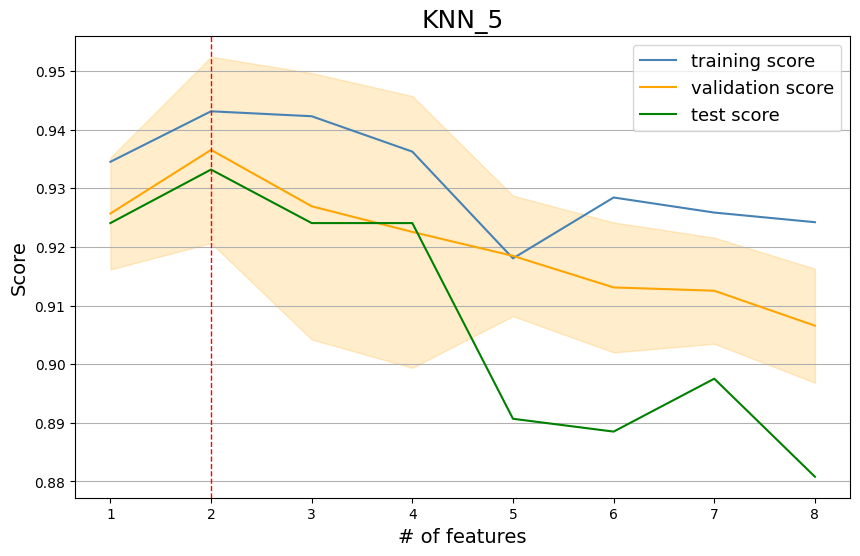

Number of features: 2
Winner feature subset: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.943
CV Score: 0.937 ± 0.016
Test Score: 0.933




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 2
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.943
CV Score: 0.937 ± 0.016
Test Score: 0.933

# of Features: 3
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO', 'fr_ether']
Train Score: 0.945
CV Score: 0.915 ± 0.014
Test Score: 0.933

# of Features: 1
Best Features: ['SMR_VSA1']
Train Score: 0.935
CV Score: 0.926 ± 0.010
Test Score: 0.924






KNN_7


008/008 [==================================================]

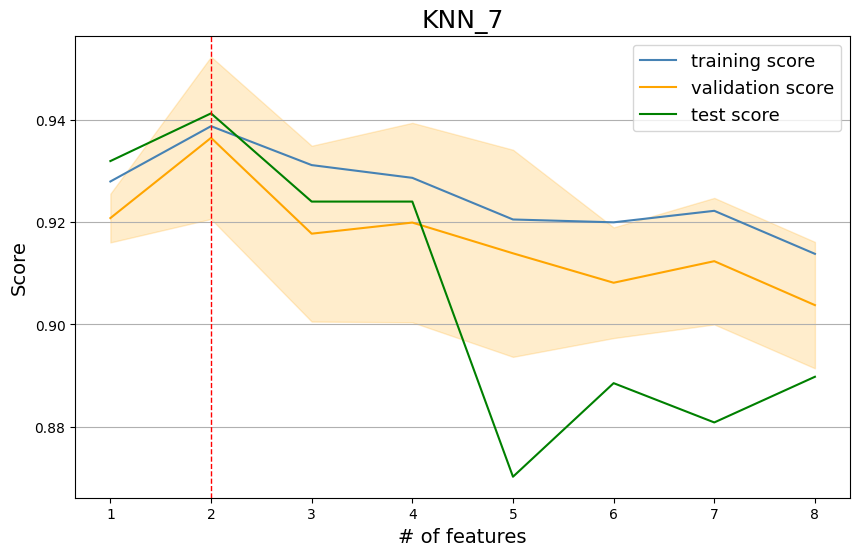

Number of features: 2
Winner feature subset: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.939
CV Score: 0.937 ± 0.016
Test Score: 0.941




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 2
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.939
CV Score: 0.937 ± 0.016
Test Score: 0.941

# of Features: 1
Best Features: ['SMR_VSA1']
Train Score: 0.928
CV Score: 0.921 ± 0.005
Test Score: 0.932

# of Features: 3
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO', 'fr_ether']
Train Score: 0.925
CV Score: 0.914 ± 0.020
Test Score: 0.933






KNN_9


008/008 [==================================================]

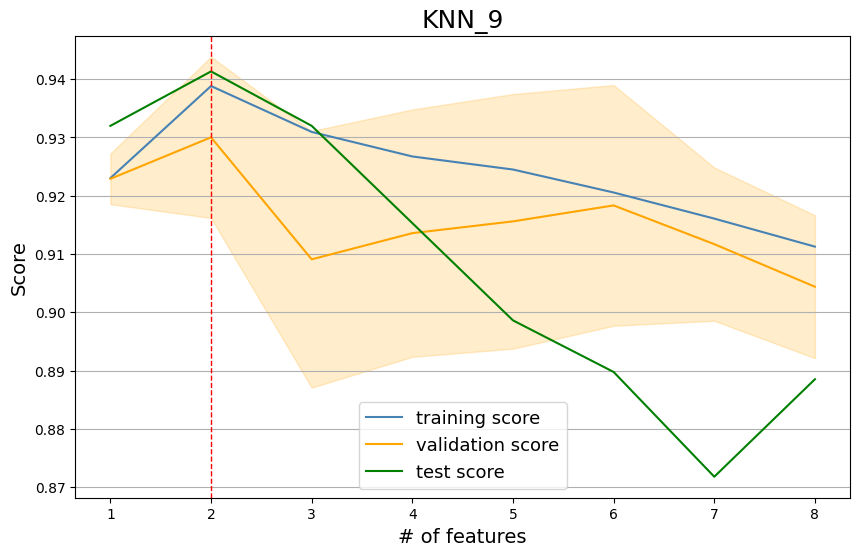

Number of features: 2
Winner feature subset: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.939
CV Score: 0.930 ± 0.014
Test Score: 0.941




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 2
Best Features: ['SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.939
CV Score: 0.930 ± 0.014
Test Score: 0.941

# of Features: 2
Best Features: ['SMR_VSA1', 'fr_ether']
Train Score: 0.925
CV Score: 0.925 ± 0.007
Test Score: 0.932

# of Features: 1
Best Features: ['SMR_VSA1']
Train Score: 0.923
CV Score: 0.923 ± 0.004
Test Score: 0.932







In [ ]:
SFS = wrappers.SequentialForwardSelection
metric = get_geometric_S

neighbours = [3,5,7,9]

for n in neighbours:
    estimator = KNeighborsClassifier(n_neighbors=n)
    estimator_string = f'KNN_{n}'
    print('\n%s\n\n'%estimator_string)
    sfs =SFS(estimator=estimator,estimator_string=estimator_string,metric=metric,max_features=max_features,cv_iter=cv_iter,logic='greater')
    sfs.fit(train_set=train_set_scaled,test_set=test_set_scaled,
            y_train=y_train,y_test=y_test)
    sfs.plot(title_size=18,title=estimator_string)
    print('\n\n\n\n-------------\n\n\n\n')

    COMB = wrappers.CombinatorialSelection
    comb = COMB(estimator=estimator,metric=metric,logic='greater')
    print('stage 1')
    df_results_1 = comb.fit_stage_1(train_set=train_set_scaled,y_train=y_train,
                                    test_set=test_set_scaled,y_test=y_test,
                                    features=sfs.feature_labels,k=k,
                                    training_threshold=training_threshold,cv_train_ratio=cv_train_ratio,cv_iter=cv_iter)
    print('\nstage2')
    try:
        df_results_2 = comb.fit_stage_2(top_n_subsets=top_n_subsets,cv_iter=cv_iter)
    except:
        print('stage 1 results not good enough')
        print("\nx x x x x x x x\n\n")
        pass
    print()
    for i in range(len(df_results_2.head(3))):
        comb.display_best(i+1)
        print()
    print('\n\n\n')

    features_best_sfs = sfs.find_best()['features']
    fitted_estimator_sfs = estimator.fit(train_set_scaled[features_best_sfs],y_train)
    joblib.dump(fitted_estimator_sfs,f'../data/{estimator_string}_SFS_estimator')
    joblib.dump(features_best_sfs,f'../data/{estimator_string}_SFS_cols')

    features_best_comb = df_results_2['feature_subsets'].values[0]
    fitted_estimator_comb = estimator.fit(train_set_scaled[features_best_comb],y_train)
    joblib.dump(fitted_estimator_comb,f'../data/{estimator_string}_COMB_estimator')
    joblib.dump(features_best_comb,f'../data/{estimator_string}_COMB_cols')

### Logistic Regression


LOGREG_l1_0.1


008/008 [==================================================]

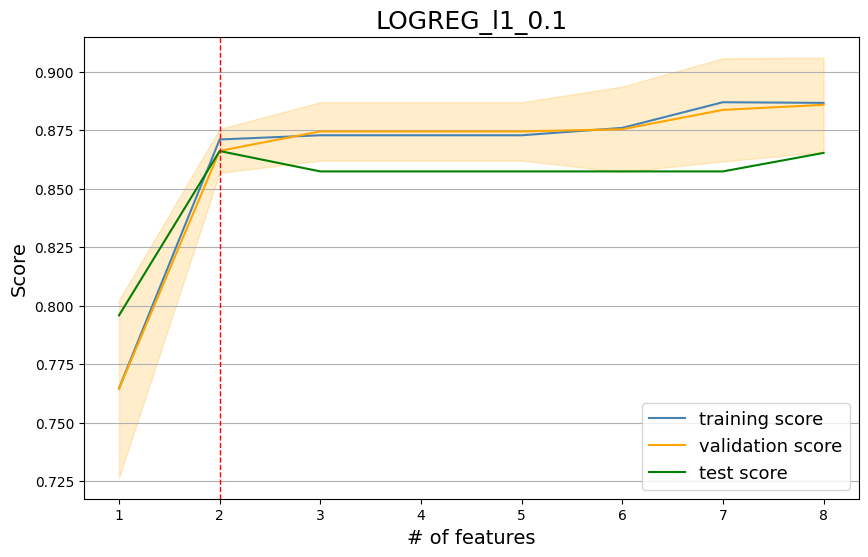

Number of features: 2
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO']
Train Score: 0.871
CV Score: 0.866 ± 0.009
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
062/062 [==================================================]
# of Features: 5
Best Features: ['MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO', 'fr_NH0', 'fr_ether']
Train Score: 0.885
CV Score: 0.871 ± 0.018
Test Score: 0.875

# of Features: 5
Best Features: ['MaxAbsEStateIndex', 'MinEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO', 'fr_ether']
Train Score: 0.875
CV Score: 0.861 ± 0.021
Test Score: 0.891

# of Features: 4
Best Features: ['MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO', 'fr_ether']
Train Score: 0.879
CV Score: 0.861 ± 0.021
Test Score: 0.875






LOGREG_l1_1


008/008 [==================================================]

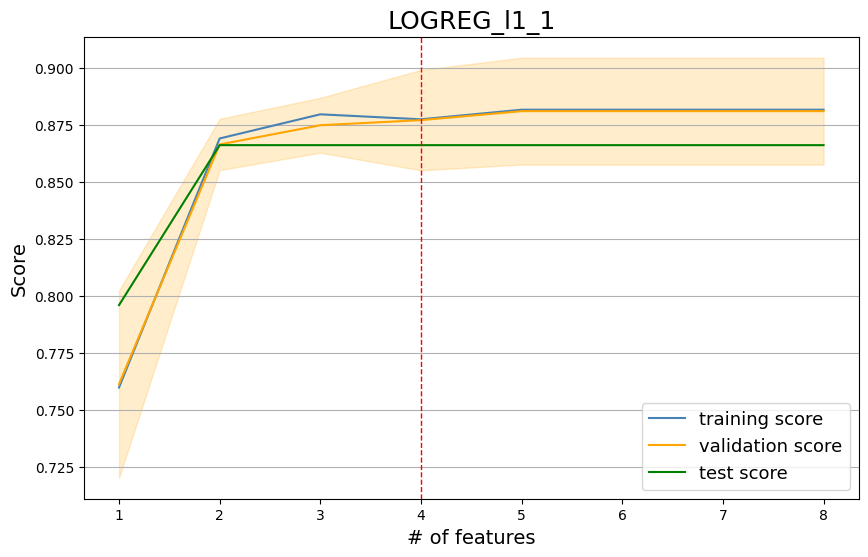

Number of features: 4
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO', 'PEOE_VSA8', 'EState_VSA6']
Train Score: 0.877
CV Score: 0.877 ± 0.022
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 5
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'VSA_EState4', 'fr_C_O_noCOO']
Train Score: 0.865
CV Score: 0.862 ± 0.016
Test Score: 0.883

# of Features: 4
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.865
CV Score: 0.857 ± 0.017
Test Score: 0.883

# of Features: 4
Best Features: ['MaxAbsEStateIndex', 'SMR_VSA1', 'VSA_EState4', 'fr_C_O_noCOO']
Train Score: 0.867
CV Score: 0.864 ± 0.013
Test Score: 0.874






LOGREG_l1_10


008/008 [==================================================]

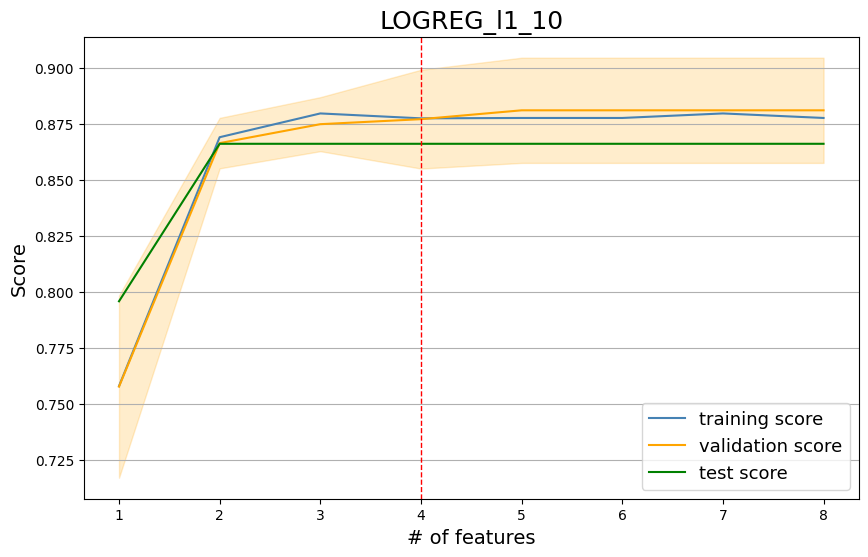

Number of features: 4
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO', 'PEOE_VSA8', 'EState_VSA6']
Train Score: 0.877
CV Score: 0.877 ± 0.022
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 4
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.863
CV Score: 0.857 ± 0.017
Test Score: 0.883

# of Features: 2
Best Features: ['MaxAbsEStateIndex', 'fr_C_O_noCOO']
Train Score: 0.869
CV Score: 0.866 ± 0.011
Test Score: 0.866

# of Features: 4
Best Features: ['MaxAbsEStateIndex', 'MinEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.863
CV Score: 0.860 ± 0.014
Test Score: 0.874






LOGREG_l2_0.1


008/008 [==================================================]

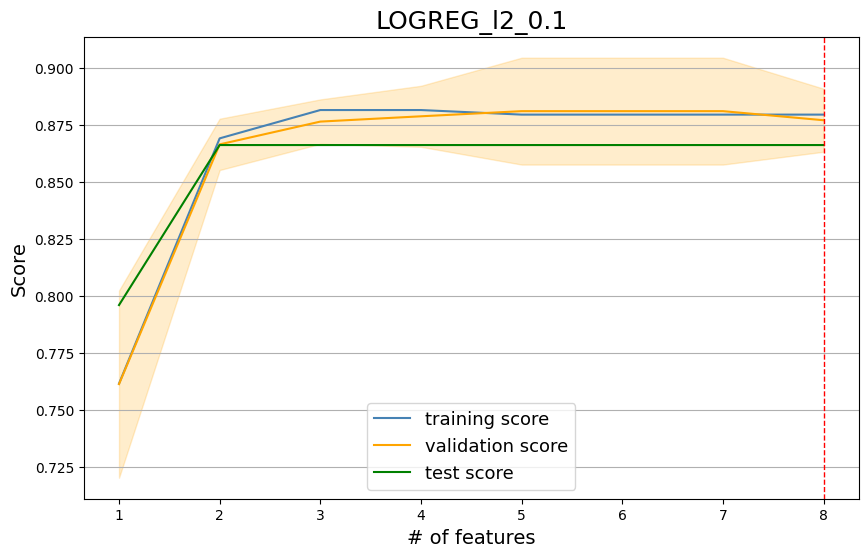

Number of features: 8
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO', 'PEOE_VSA8', 'EState_VSA6', 'SlogP_VSA4', 'BalabanJ', 'PEOE_VSA9', 'FpDensityMorgan3']
Train Score: 0.879
CV Score: 0.877 ± 0.014
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 3
Best Features: ['MaxAbsEStateIndex', 'VSA_EState4', 'fr_C_O_noCOO']
Train Score: 0.873
CV Score: 0.871 ± 0.015
Test Score: 0.866

# of Features: 3
Best Features: ['MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.869
CV Score: 0.859 ± 0.022
Test Score: 0.874

# of Features: 5
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'VSA_EState4', 'fr_C_O_noCOO']
Train Score: 0.862
CV Score: 0.857 ± 0.026
Test Score: 0.883






LOGREG_l2_1


008/008 [==================================================]

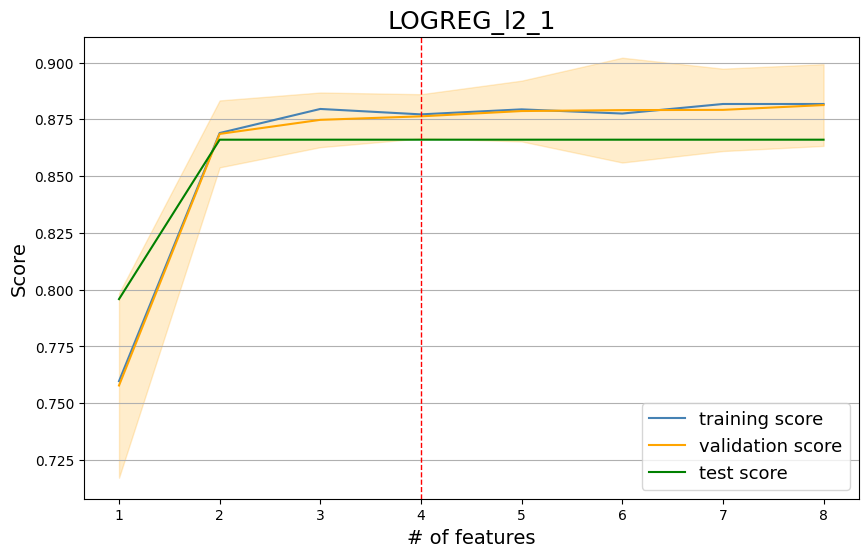

Number of features: 4
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO', 'PEOE_VSA8', 'fr_allylic_oxid']
Train Score: 0.877
CV Score: 0.876 ± 0.010
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 2
Best Features: ['MaxAbsEStateIndex', 'fr_C_O_noCOO']
Train Score: 0.869
CV Score: 0.869 ± 0.015
Test Score: 0.866

# of Features: 4
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.865
CV Score: 0.855 ± 0.016
Test Score: 0.883

# of Features: 3
Best Features: ['MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.865
CV Score: 0.862 ± 0.011
Test Score: 0.874






LOGREG_l2_10


008/008 [==================================================]

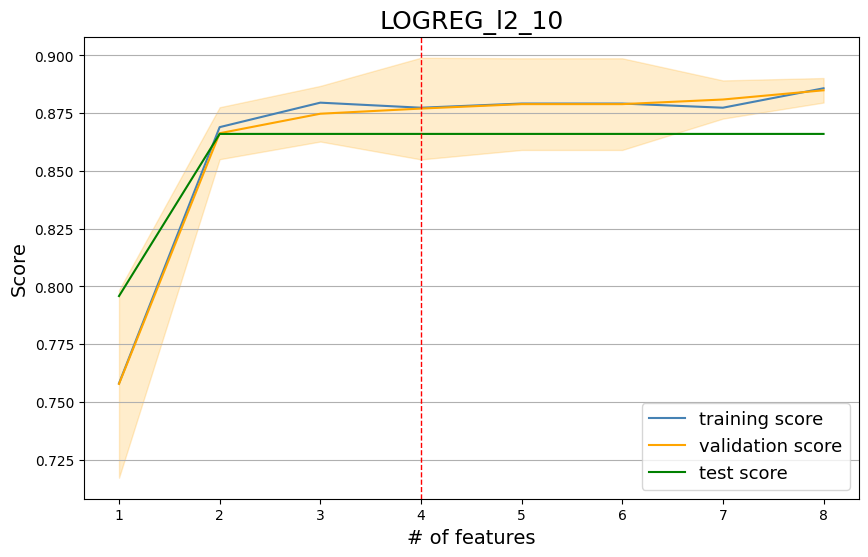

Number of features: 4
Winner feature subset: ['MaxAbsEStateIndex', 'fr_C_O_noCOO', 'PEOE_VSA8', 'EState_VSA6']
Train Score: 0.877
CV Score: 0.877 ± 0.022
Test Score: 0.866




-------------




stage 1
406/406 [==================================================]
stage2
031/031 [==================================================]
# of Features: 4
Best Features: ['EState_VSA9', 'MaxAbsEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.863
CV Score: 0.857 ± 0.017
Test Score: 0.883

# of Features: 2
Best Features: ['MaxAbsEStateIndex', 'fr_C_O_noCOO']
Train Score: 0.869
CV Score: 0.866 ± 0.011
Test Score: 0.866

# of Features: 4
Best Features: ['MaxAbsEStateIndex', 'MinEStateIndex', 'SMR_VSA1', 'fr_C_O_noCOO']
Train Score: 0.863
CV Score: 0.860 ± 0.014
Test Score: 0.874







In [126]:
SFS = wrappers.SequentialForwardSelection
metric = get_geometric_S

arguments = [{'penalty':'l1','C':0.1},
             {'penalty':'l1','C':1},
             {'penalty':'l1','C':10},
             {'penalty':'l2','C':0.1},
             {'penalty':'l2','C':1},
             {'penalty':'l2','C':10}]

for arg in arguments:
    estimator = LogisticRegression(**arg,random_state=1,solver='liblinear')
    estimator_string = f'LOGREG_{arg['penalty']}_{arg['C']}'
    print('\n%s\n\n'%estimator_string)
    sfs =SFS(estimator=estimator,estimator_string=estimator_string,metric=metric,max_features=max_features,cv_iter=cv_iter,logic='greater')
    sfs.fit(train_set=train_set_scaled,test_set=test_set_scaled,
            y_train=y_train,y_test=y_test)
    sfs.plot(title_size=18,title=estimator_string)
    print('\n\n\n\n-------------\n\n\n\n')

    COMB = wrappers.CombinatorialSelection
    comb = COMB(estimator=estimator,metric=metric,logic='greater')
    print('stage 1')
    df_results_1 = comb.fit_stage_1(train_set=train_set_scaled,y_train=y_train,
                                    test_set=test_set_scaled,y_test=y_test,
                                    features=sfs.feature_labels,k=k,
                                    training_threshold=training_threshold,cv_train_ratio=cv_train_ratio,cv_iter=cv_iter)
    print('\nstage2')
    try:
        df_results_2 = comb.fit_stage_2(top_n_subsets=top_n_subsets,cv_iter=cv_iter)
    except:
        print('stage 1 results not good enough')
        print("\nx x x x x x x x\n\n")
        pass
    print()
    for i in range(len(df_results_2.head(3))):
        comb.display_best(i+1)
        print()
    print('\n\n\n')

    features_best_sfs = sfs.find_best()['features']
    fitted_estimator_sfs = estimator.fit(train_set_scaled[features_best_sfs],y_train)
    joblib.dump(fitted_estimator_sfs,f'{estimator_string}_SFS_estimator')
    joblib.dump(features_best_sfs,f'{estimator_string}_SFS_cols')

    features_best_comb = df_results_2['feature_subsets'].values[0]
    fitted_estimator_comb = estimator.fit(train_set_scaled[features_best_comb],y_train)
    joblib.dump(fitted_estimator_comb,f'../data/{estimator_string}_COMB_estimator')
    joblib.dump(features_best_comb,f'../data/{estimator_string}_COMB_cols')